https://huggingface.co/kritsadaK/UltraInteract-Llama-FT

# Overview

1. Uninstall conflicting packages and install required versions.
2. Load and prepare the dataset.
3. Configure and load the pre-trained model with quantization.
4. Set up Parameter-Efficient Fine-Tuning (PEFT) with LoRA.
5. Define training arguments and initialize the trainer.
6. Train the model.
7. Save and upload the fine-tuned model to Hugging Face Hub.
8. Load the model from the Hub and test it with sample prompts.

# introduce LoRA for llm tasks

https://www.run.ai/guides/generative-ai/lora-fine-tuning

https://www.sub-brain.com/datait/lora/

https://www.mercity.ai/blog-post/guide-to-fine-tuning-llms-with-lora-and-qlora

LLM Fine-Tuning

Definition: LLM fine-tuning customizes pre-trained language models (like GPT-4, PaLM 2) for specific tasks or domains. Rather than retraining the entire model, fine-tuning adapts existing general knowledge to specific needs, which is more efficient and less resource-intensive.

Challenges: Training LLMs is highly resource-intensive, often limited to large tech organizations. Fine-tuning opens opportunities for smaller groups by enabling them to customize LLMs without the massive computational cost.

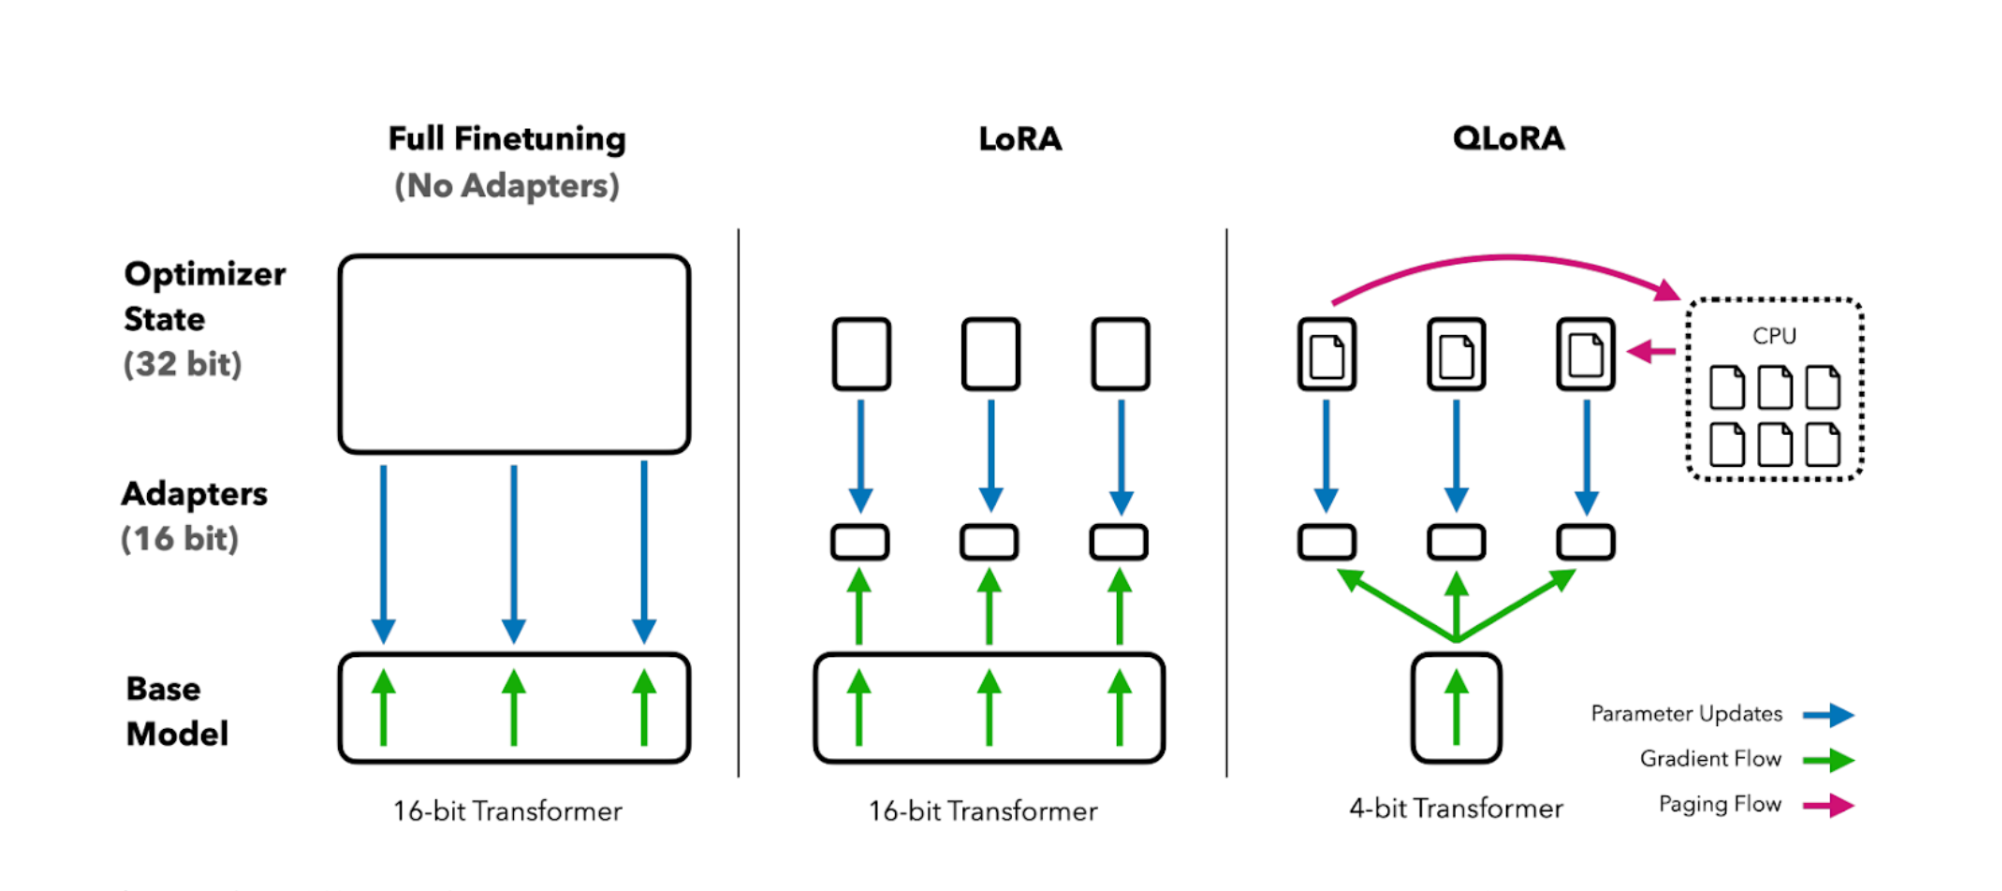

 LoRA and QLoRA make LLM fine-tuning more accessible by reducing resource requirements and enabling more efficient, flexible, and scalable model adaptations for a wide range of users.

## **LoRA (Low-Rank Adaptation) for Fine-Tuning**

### **Purpose**
LoRA enhances the accessibility of fine-tuning large language models (LLMs) by minimizing the required resources. It achieves this by freezing the original model weights and applying changes through smaller, low-rank matrices, enabling efficient fine-tuning even on smaller setups, including a single machine.

### **Method**
LoRA splits the model’s weight adjustments (∆W) into two smaller matrices (A and B). This approach reduces the number of parameters to be updated, thereby accelerating the fine-tuning process.

### **Advantages**
1. **Efficiency**: Lowers memory and processing requirements by focusing on specific weights.
2. **Resource Savings**: Requires fewer computational resources, making it feasible for organizations with limited resources.
3. **Preservation of Core Knowledge**: Maintains the original weights, preserving the pre-trained model's general understanding.

## **QLoRA (Quantized Low-Rank Adaptation)**

### **What’s New**
QLoRA enhances LoRA by integrating 4-bit quantization. This innovation allows large models, such as those with 65 billion parameters, to be fine-tuned on a single 48GB GPU without compromising on quality. It employs techniques like NF4 (NormalFloat 4-bit precision) and paged optimizers to maximize memory efficiency, making fine-tuning accessible to a broader range of users.

### **Example Model**
The Guanaco model utilizes QLoRA to achieve performance levels comparable to ChatGPT, with just a day of training on a single GPU.

## **Tips for Fine-Tuning with LoRA and QLoRA**

- **Single GPU Training**: Leverage LoRA's reduced memory needs to train large models (e.g., 7B parameters) on a single GPU.
- **Apply LoRA Across Multiple Layers**: Fine-tune additional layers for complex tasks to enhance model performance.
- **Increase Training Epochs**: For specialized tasks, extend training epochs to achieve better refinement.
- **Use Learning Rate Schedulers**: Implement learning rate schedulers to gradually reduce the learning rate, ensuring stable training and improved results.
- **Ensure Consistency**: Maintain consistent environment and settings for reproducible outcomes.

### **Optimizing Infrastructure with Run**
- **Automated Resource Management**: Run provides automated resource management and GPU orchestration, maximizing GPU usage and reducing costs during LLM fine-tuning.
- **Dynamic Resource Allocation**: Allows for flexible resource allocation to meet varying demands.
- **Quota Management and Visibility**: Enhances team efficiency by managing quotas and providing visibility into resource usage, streamlining machine learning workflows.

## here is simple lora with the lite llama model and load this model in hugging face model

In [ ]:
# Step 1: Uninstall conflicting packages
!pip uninstall -y transformers trl

# Step 2: Install the required versions of transformers and trl
!pip install transformers>=4.46.0 trl --quiet


Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Successfully uninstalled transformers-4.44.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Install required libraries
!pip install accelerate peft bitsandbytes transformers trl --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.8 MB/s eta 0:00:00


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU device name: Tesla T4


# All Parameters:

more detail

https://abvijaykumar.medium.com/fine-tuning-llm-parameter-efficient-fine-tuning-peft-lora-qlora-part-2-d8e23877ac6f

###  Configure Quantization Settings for 4-bit Precision

```python
compute_dtype = getattr(torch, "float16")
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)
```

- **Purpose**: Configure the model to use 4-bit quantization to reduce memory usage and computational load.
- **Parameters**:
  - `load_in_4bit`: Enables loading the model in 4-bit precision.
  - `bnb_4bit_quant_type`: Sets the quantization type to `nf4` (Normal Float 4).
  - `bnb_4bit_compute_dtype`: Specifies the computation data type (`float16`).
  - `bnb_4bit_use_double_quant`: Disables double quantization.


### Load the Model with Quantization

```python
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map="auto"
)
model.config.use_cache = False
```

- **Purpose**: Load the pre-trained model with the specified quantization settings.
- **Actions**:
  - Use `AutoModelForCausalLM` to load the causal language model.
  - Apply the quantization configuration.
  - Set `device_map="auto"` to automatically distribute the model across available devices.
  - Disable the cache (`use_cache = False`) to prevent errors during fine-tuning with gradient checkpointing.


### Set Up PEFT Configuration with LoRA

```python
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)
```

- **Purpose**: Configure Parameter-Efficient Fine-Tuning using LoRA (Low-Rank Adaptation).
- **Parameters**:
  - `lora_alpha`: A scaling factor for LoRA.
  - `lora_dropout`: Dropout rate for LoRA layers.
  - `r`: Rank of the LoRA matrices.
  - `bias`: Specifies that no bias parameters are updated.
  - `task_type`: Specifies the task as causal language modeling.


### Define Training Arguments

```python
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)
```

- **Purpose**: Set up the training configurations.
- **Parameters**:
  - `output_dir`: Directory to save the training results.
  - `num_train_epochs`: Number of training epochs (set to 1 for quick experimentation).
  - `per_device_train_batch_size`: Batch size per device during training.
  - `gradient_accumulation_steps`: Number of steps to accumulate gradients before updating.
  - `optim`: Optimizer to use (`paged_adamw_32bit` for memory efficiency).
  - `save_steps` and `logging_steps`: Frequency of saving checkpoints and logging.
  - `learning_rate`: Learning rate for the optimizer.
  - `weight_decay`: Weight decay for regularization.
  - `fp16` and `bf16`: Disable half-precision training.
  - `max_grad_norm`: Maximum gradient norm for clipping.
  - `warmup_ratio`: Ratio of warmup steps in the learning rate scheduler.
  - `group_by_length`: Whether to group samples of similar lengths to optimize training.
  - `lr_scheduler_type`: Type of learning rate scheduler.
  - `report_to`: Integration with TensorBoard for logging.



### Initialize the Trainer

```python
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field=text_field,
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)
```

- **Purpose**: Set up the `SFTTrainer` (Sequence Fine-Tuning Trainer) with the model, dataset, and training configurations.
- **Parameters**:
  - `model`: The pre-trained model with quantization.
  - `train_dataset`: The dataset to use for training.
  - `peft_config`: PEFT configuration with LoRA.
  - `dataset_text_field`: The field in the dataset containing the text (`"content"`).
  - `max_seq_length`: Maximum sequence length for inputs.
  - `tokenizer`: The tokenizer to process text data.
  - `args`: Training arguments.
  - `packing`: Whether to pack multiple sequences into a single input (set to `False`).



# Code

In [ ]:
# Import necessary libraries
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import LoraConfig
from trl import SFTTrainer

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Define model and dataset names
base_model = "NousResearch/Llama-2-7b-chat-hf"
guanaco_dataset = "openbmb/UltraInteract_sft"
new_model = "llama-2-7b-chat-ultrainteract"

# Load dataset
dataset = load_dataset(guanaco_dataset, split="train")

# Inspect the dataset structure to find the correct field name for the text
print("Dataset sample:", dataset[0])

# Set the correct dataset text field based on inspection
text_field = "content"

# Configure quantization settings for 4-bit precision
compute_dtype = getattr(torch, "float16")
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map="auto"
)
model.config.use_cache = False

# Load tokenizer and configure padding
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Set up Parameter Efficient Fine-Tuning (PEFT) configuration
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

# Define training arguments
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

# Initialize the trainer with dataset and model configurations
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field=text_field,
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

# Start the training process
trainer.train()

# Save the fine-tuned model and tokenizer
trainer.model.save_pretrained(new_model)
trainer.tokenizer.save_pretrained(new_model)


# Load the Model and Tokenizer from Hugging Face

In [ ]:
from huggingface_hub import login

login("private key")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository

# Define Hugging Face repository name
repo_name = "kritsadaK/UltraInteract-Llama-FT"

# Upload the model and tokenizer to the repository
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

Repo card metadata block was not found. Setting CardData to empty.


model.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/763 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kritsadaK/UltraInteract-Llama-FT/commit/d48fda36ec69e5177cbf069732435376a276cacd', commit_message='Upload tokenizer', commit_description='', oid='d48fda36ec69e5177cbf069732435376a276cacd', pr_url=None, pr_revision=None, pr_num=None)

# Check and evalute model and the output

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the model and tokenizer from Hugging Face
model = AutoModelForCausalLM.from_pretrained("kritsadaK/UltraInteract-Llama-FT")
tokenizer = AutoTokenizer.from_pretrained("kritsadaK/UltraInteract-Llama-FT")

# Test the model with a sample prompt
prompt = "<s>[INST] Who is Albert Einstein? [/INST]"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of the model checkpoint at kritsadaK/UltraInteract-Llama-FT were not used when initializing LlamaForCausalLM: ['model.layers.0.self_attn.q_proj.base_layer.weight', 'model.layers.0.self_attn.q_proj.base_layer.weight.absmax', 'model.layers.0.self_attn.q_proj.base_layer.weight.quant_map', 'model.layers.0.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4', 'model.layers.0.self_attn.q_proj.lora_A.default.weight', 'model.layers.0.self_attn.q_proj.lora_B.default.weight', 'model.layers.0.self_attn.v_proj.base_layer.weight', 'model.layers.0.self_attn.v_proj.base_layer.weight.absmax', 'model.layers.0.self_attn.v_proj.base_layer.weight.quant_map', 'model.layers.0.self_attn.v_proj.base_layer.weight.quant_state.bitsandbytes__nf4', 'mo

[INST] Who is Albert Einstein? [/INST]-}scheidVBbachVB


In [ ]:
response = model.generate(
    inputs["input_ids"].to("cuda"),
    max_new_tokens=50,  # Adjust token length as needed
    temperature=0.7,     # Experiment with temperature for creativity
    do_sample=True
)
print(tokenizer.decode(response[0], skip_special_tokens=True))


[INST] Who is Albert Einstein? [/INST]VBerdings戸igerVBüs graduüskliumVBbachVBklüsror HumbachbachbachbachbachVBklbachVB Humerdingskl relief reliefVB rapklVB RépubliqueklVBmicrosoftischer rapischer gradu HumbachbachiumVB graduime


In [ ]:
input_text = "<s>[INST] What is quantum physics? [/INST]</s>"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
output = model.generate(inputs["input_ids"], max_new_tokens=50, temperature=0.7, top_p=0.9)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


[INST] What is quantum physics? [/INST]</s>VBSelectorischeriummicrosoft魔魔ror graduiumiskaija-}ischerijeVBекVBigerijaüs stor relieftedbachigerbachVBerdingsVBimeklек cum Humime Pero RépubliqueimeiumɛSelector République rapекime CourDrawischer République


In [ ]:
# Import necessary libraries
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Initialize the tokenizer and model
model_name = "kritsadaK/UltraInteract-Llama-FT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")

# Define a math question prompt
input_text = "<s>[INST] What is 5 + 3? [/INST]</s>"

# Encode the input and generate a response
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
output = model.generate(inputs["input_ids"], max_new_tokens=50, temperature=0.7, top_p=0.9)

# Decode and print the output
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated response:", generated_text)


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 18662 has 14.73 GiB memory in use. Of the allocated memory 14.32 GiB is allocated by PyTorch, and 300.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## **Key Takeaways**

- **Efficient Fine-Tuning**: The code demonstrates fine-tuning using Parameter-Efficient Fine-Tuning techniques (LoRA), enabling adaptation without updating all parameters.
- **Memory Optimization**: Utilizes 4-bit quantization for reduced memory footprint and computational efficiency, making it feasible on limited hardware.
- **Deployment Ready**: Fine-tuned model and tokenizer are uploaded to Hugging Face Hub, easing sharing and deployment.
- **Performance Testing**: Includes examples for testing model responses with different prompts.

## **Additional Notes**

- **Tokenization**: Prompts use special tokens for models like Llama to handle formatting.
- **Parameter Tuning**: Adjusting `temperature` and `top_p` affects response diversity and creativity; lower values yield deterministic outputs, higher values increase randomness.
- **CUDA Availability**: Ensure CUDA is available for GPU execution; otherwise, adjust for CPU or obtain GPU access.

---

## **Conclusion**

The code efficiently fine-tunes large language models using advanced techniques, allowing adaptation to specific tasks and easy deployment via Hugging Face Hub.